# MPS Tutorial
This sample will show you how to use the Aria MPS data via the MPS apis.
Please refer to the MPS wiki for more information about data formats and schemas

### Notebook stuck?
Note that because of Jupyter and Plotly issues, sometimes the code may stuck at visualization. We recommend **restart the kernels** and try again to see if the issue is resolved.


## Download the MPS sample dataset locally
> The sample dataset will get downloaded to a **tmp** folder by default. Please modify the path if necessary

In [133]:
# 2b28b4d0-65c2-4d78-bf0f-d2b9d3523957

from google.colab import drive
import os
drive.flush_and_unmount()
drive.mount('/content/drive/')

aria_path = "/content/drive/MyDrive/Aria Workshop/person_a/VRS"

Mounted at /content/drive/


In [134]:
!ls /content/drive/MyDrive/'Aria Workshop'

'apple health'					        person1b.png
 demo_tracking_gaze.mp4				        person1c.png
 ecg1.txt					        person2b.png
 ecg2.txt					        person2c.png
 EchoThreads_Final.gslides			        person_a
 end_steps.ipynb				        person_b
 gaze_coords_2b28b4d0-65c2-4d78-bf0f-d2b9d3523957.csv   spotify
 maps						       'system diagram.drawio'
 Music_Summary.ipynb				        test.mp4


In [135]:
from projectaria_tools.core import data_provider, mps
from projectaria_tools.core.stream_id import StreamId
import numpy as np

# Load the VRS file
vrsfile = os.path.join(aria_path, "a.vrs")

# Trajectory and global points
#closed_loop_trajectory = os.path.join(mps_sample_path, "trajectory","closed_loop_trajectory.csv")
#global_points = os.path.join(mps_sample_path, "trajectory", "global_points.csv.gz")

# Eye Gaze : in the zip file of MPS
generalized_eye_gaze_path = "/content/general_eye_gaze.csv" #os.path.join(mps_sample_path, "eye_gaze", "general_eye_gaze.csv")
#calibrated_eye_gaze_path = os.path.join(mps_sample_path, "eye_gaze", "calibrated_eye_gaze.csv")

# Create data provider and get T_device_rgb
provider = data_provider.create_vrs_data_provider(vrsfile)
# Since we want to display the position of the RGB camera, we are querying its relative location
# from the device and will apply it to the device trajectory.
T_device_RGB = provider.get_device_calibration().get_transform_device_sensor("camera-rgb")

## Load trajectory and global points
#mps_trajectory = mps.read_closed_loop_trajectory(closed_loop_trajectory)
#points = mps.read_global_point_cloud(global_points, mps.StreamCompressionMode.GZIP)

## Load eyegaze
generalized_eye_gazes = mps.read_eyegaze(generalized_eye_gaze_path)
#calibrated_eye_gazes = mps.read_eyegaze(calibrated_eye_gaze_path)

## Load the trajectory, point cloud and eye gaze using the MPS apis

# Conversion MSP to MP4

In [136]:
#!/usr/bin/env python3
# Copyright (c) Meta Platforms, Inc. and affiliates.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import argparse
import json
import os
import shutil
import tempfile

import numpy as np
from moviepy.editor import AudioFileClip
from moviepy.video.io.VideoFileClip import VideoClip

from projectaria_tools.core import data_provider
from projectaria_tools.core.sensor_data import TimeDomain
from projectaria_tools.core.stream_id import StreamId
#from projectaria_tools.core.vrs import extract_audio_track


def extract_audio(vrs_file_path: str) -> str:
    """Extract audio from a VRS file as a wav file in a temporary folder."""
    temp_folder = tempfile.mkdtemp()
    if not temp_folder:
        return None
    # else continue process vrs audio extraction
    json_output_string = extract_audio_track(
        vrs_file_path, os.path.join(temp_folder, "audio.wav")
    )
    json_output = json.loads(json_output_string)  # Convert string to Dict
    if json_output and json_output["status"] == "success":
        return json_output["output"]
    # Else we were not able to export a Wav file from the VRS file
    return None


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--vrs",
        type=str,
        required=True,
        help="path to the VRS file to be converted to a video",
    )
    parser.add_argument(
        "--output_video",
        type=str,
        required=True,
        help="path to the VIDEO file you want to create",
    )
    parser.add_argument(
        "--downsample",
        type=int,
        required=False,
        default=2,
        help="Downsampling factor on VRS images (Must be >=1)",
    )
    return parser.parse_args()


class Vrs2MoviePyFrameConverter:
    """
    Class used to convert the VRS RGB frame to a moviepy Video Clip.
    A Vrs2MoviePyFrameConverter object is defined as callable to be used as a make_frame(t) functor by moviepy.
    """

    def sample_frame_and_timestamp(self, image_data_and_record) -> [np.ndarray, int]:
        """
        Return the image frame and corresponding timestamp.
            Image is down sampled and rotated if required.
        """
        img = image_data_and_record.image_data_and_record()[0].to_numpy_array().copy()

        if self.down_sampling_factor_ > 1:
            img = img[:: self.down_sampling_factor_, :: self.down_sampling_factor_]
        # Rotate image
        img = np.rot90(img, -1)

        capture_timestamp = image_data_and_record.image_data_and_record()[
            1
        ].capture_timestamp_ns
        return [img, capture_timestamp]

    def __init__(self, vrs_path: str, down_sampling_factor: int = 1):
        self.down_sampling_factor_ = down_sampling_factor

        ##
        # Initialize the VRS data provider
        self.provider_ = data_provider.create_vrs_data_provider(vrs_path)
        if not self.provider_:
            raise ValueError(f"vrs file: '{vrs_path}' cannot be read")

        self.rgb_stream_id_ = StreamId("214-1")

        ##
        # Configure a deliver queue to provide only RGB image data stream

        deliver_option = self.provider_.get_default_deliver_queued_options()
        deliver_option.deactivate_stream_all()
        deliver_option.activate_stream(self.rgb_stream_id_)

        self.seq_ = self.provider_.deliver_queued_sensor_data(deliver_option)
        self.iter_data_ = iter(self.seq_)
        image_data_and_record = next(self.iter_data_)
        self.last_valid_frame_, self.last_timestamp_ = self.sample_frame_and_timestamp(
            image_data_and_record
        )
        self.first_timestamp_ = self.last_timestamp_
        self.dropped_frames_count_ = 0

    def stream_fps(self) -> int:
        """Collect stream characteristic, Get the time period between two image sample."""
        return int(self.provider_.get_nominalRateHz(self.rgb_stream_id_))

    def stream_duration(self) -> int:
        """Return the RGB stream duration in seconds."""
        t_first = self.provider_.get_first_time_ns(
            self.rgb_stream_id_, TimeDomain.DEVICE_TIME
        )
        t_last = self.provider_.get_last_time_ns(
            self.rgb_stream_id_, TimeDomain.DEVICE_TIME
        )
        import math

        # Keeping only integer seconds (no decimals)
        duration_in_seconds = math.floor((t_last - t_first) / 1e9)
        return duration_in_seconds

    def dropped_frames_count(self) -> int:
        """
        Return the number of counted frame drop (frame that did not match the expect timestamp)
        """
        return self.dropped_frames_count_

    def __call__(self, t) -> np.ndarray:
        """
        Create a functor compatible with the make_frame(t) functor concept of moviePy VideoClip.
        This function return VRS frame in time alignment with the time {t} request of moviePy.
        - If a frame is not present as a given expected time, we count the frame as missing/dropped and return the last valid frame.
        """
        try:
            moviepy_timestamp_us = t * 1e9
            vrs_timestamp = self.last_timestamp_ - self.first_timestamp_

            # If time match we return the last frame
            if vrs_timestamp > moviepy_timestamp_us:
                # VRS is in advance, so we return the last frame we collected
                self.dropped_frames_count_ += 1
                return self.last_valid_frame_
            else:
                obj = next(self.iter_data_)
                # We get a new image from the queue
                (
                    self.last_valid_frame_,
                    self.last_timestamp_,
                ) = self.sample_frame_and_timestamp(obj)
            return self.last_valid_frame_

        except StopIteration:
            print("We have exhausted the VRS stream, keep sending last VRS frame")
            return self.last_valid_frame_





In [137]:
audio_path = None
frame_converter = Vrs2MoviePyFrameConverter(vrsfile, 1)
duration_in_seconds = frame_converter.stream_duration()
    # Create a VideoClip of the desired duration, and using the Vrs Source
video_writer_clip = VideoClip(frame_converter, duration=duration_in_seconds)
    # Add the audio as audio clip if any
    #if audio_path:
    #    audio_clip = AudioFileClip(audio_path)
    #    video_writer_clip = video_writer_clip.set_audio(audio_clip)

    # Configure the VideoWriter and run the process
output_video_fps = frame_converter.stream_fps()
video_writer_clip.write_videofile("test.mp4", fps=output_video_fps)
video_writer_clip.close()

# If audio file has been extracted, remove the containing temporary folder that we created
#if audio_path:
#shutil.rmtree(os.path.dirname(audio_path))

print("VRS to MP4 summary:")
print(f"Created a {duration_in_seconds} seconds video.")
print(f"- FPS: {output_video_fps}")
print(f"- Drop frame(s) count: {frame_converter.dropped_frames_count()}")


Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4
VRS to MP4 summary:
Created a 5 seconds video.
- FPS: 1
- Drop frame(s) count: 1


In [138]:
output_video_fps

1

## Helper functions

In [139]:
import plotly.graph_objs as go
from matplotlib import pyplot as plt

# Helper function to build the frustum
def build_cam_frustum(transform_world_device):
    points = np.array([[0, 0, 0], [0.5, 0.5, 1], [-0.5, 0.5, 1], [-0.5, -0.5, 1], [0.5, -0.5, 1]]) * 0.6
    transform_world_rgb = transform_world_device @ T_device_RGB
    points_transformed = transform_world_rgb @ points.transpose()
    return go.Mesh3d(x=points_transformed[0,:], y=points_transformed[1, :], z=points_transformed[2, :],
        i=[0, 0, 0, 0, 1, 1], j=[1, 2, 3, 4, 2, 3], k=[2, 3, 4, 1, 3, 4], showscale=False, visible=False,
        colorscale="jet", intensity=points[:, 2], opacity=1.0, hoverinfo='none')

# Helper function to get nearest eye gaze for a timestamp
def get_nearest_eye_gaze(eye_gazes, query_timestamp_ns):
    return eye_gazes[min(range(len(eye_gazes)), key = lambda i: abs(eye_gazes[i].tracking_timestamp.total_seconds()*1e9 - query_timestamp_ns))]

# Helper function to project a gaze output onto the RGB image, assuming a fixed depth of 1m
def get_gaze_center_in_pixels(eye_gaze):
    depth_m = 1.0 # Select a fixed depth of 1m
    gaze_center_in_cpf = mps.get_eyegaze_point_at_depth(eye_gaze.yaw, eye_gaze.pitch, depth_m)
    transform_cpf_sensor = provider.get_device_calibration().get_transform_cpf_sensor(provider.get_label_from_stream_id(rgb_stream_id))
    gaze_center_in_camera = transform_cpf_sensor.inverse() @ gaze_center_in_cpf
    gaze_center_in_camera = gaze_center_in_camera / gaze_center_in_camera[2]
    gaze_center_in_pixels = cam_calibration.project(gaze_center_in_camera)
    return gaze_center_in_pixels

## Visualize the trajectory and point cloud in a 3D interactive plot
* Load trajectory
* Load global point cloud
* Render dense trajectory (1Khz) as points.
* Render subsampled 6DOF poses via camera frustum. Use calibration to transform RGB camera pose to world frame
* Render subsampled point cloud

_Please wait a minute for all the data to load. Zoom in to the point cloud and adjust your view. Then use the time slider to move the camera_

In [140]:
# Load all world positions from the trajectory
traj = np.empty([len(mps_trajectory), 3])
for i in range(len(mps_trajectory)):
    traj[i, :] = mps_trajectory[i].transform_world_device.translation()

# Subsample trajectory for quick display
skip = 1000
mps_trajectory_subset = mps_trajectory[::skip]
steps = [None]*len(mps_trajectory_subset)

# Load each pose as a camera frustum trace
cam_frustums = [None]*len(mps_trajectory_subset)

for i in range(len(mps_trajectory_subset)):
    pose = mps_trajectory_subset[i]
    cam_frustums[i] = build_cam_frustum(pose.transform_world_device)
    timestamp = pose.tracking_timestamp.total_seconds()
    step = dict(method="update", args=[{"visible": [False] * len(cam_frustums) + [True] * 2}, {"title": "Trajectory and Point Cloud"},], label=timestamp,)
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps[i] = step
    cam_frustums[0].visible = True

# Filter the point cloud by inv depth and depth and load
threshold_invdep = 0.001
threshold_dep = 0.15
skip = 1
point_cloud = np.empty([len(points), 3])
j = 0
for i in range(0, len(points), skip):
    if (points[i].inverse_distance_std < threshold_invdep and points[i].distance_std < threshold_dep):
        point_cloud[j,:] = points[i].position_world
        j=j+1
point_cloud = point_cloud[:j,:]

# Create slider to allow scrubbing and set the layout
sliders = [dict(currentvalue={"suffix": " s", "prefix": "Time :"}, pad={"t": 5}, steps=steps,)]
layout = go.Layout(sliders=sliders, scene=dict(bgcolor='lightgray', dragmode='orbit', aspectmode='data', xaxis_visible=False, yaxis_visible=False,zaxis_visible=False))

# Plot trajectory and point cloud
# We color the points by their z coordinate
trajectory = go.Scatter3d(x=traj[:, 0], y=traj[:, 1], z=traj[:, 2], mode="markers", marker={"size": 2, "opacity": 0.8, "color": "red"}, name="Trajectory", hoverinfo='none')
global_points = go.Scatter3d(x=point_cloud[:, 0], y=point_cloud[:, 1], z=point_cloud[:, 2], mode="markers",
    marker={"size" : 1.5, "color": point_cloud[:, 2], "cmin": -1.5, "cmax": 2, "colorscale": "viridis",},
    name="Global Points", hoverinfo='none')

# draw
plot_figure = go.Figure(data=cam_frustums + [trajectory, global_points], layout=layout)
plot_figure.show()

## Visualize generalized and calibrated eye gaze projection on an rgb image.
* Load Eyegaze MPS output
* Select a random RGB frame
* Find the closest eye gaze data for the RGB frame
* Project the eye gaze for the RGB frame by **using a fixed depth of 1m**.
* Show the gaze cross on the RGB image

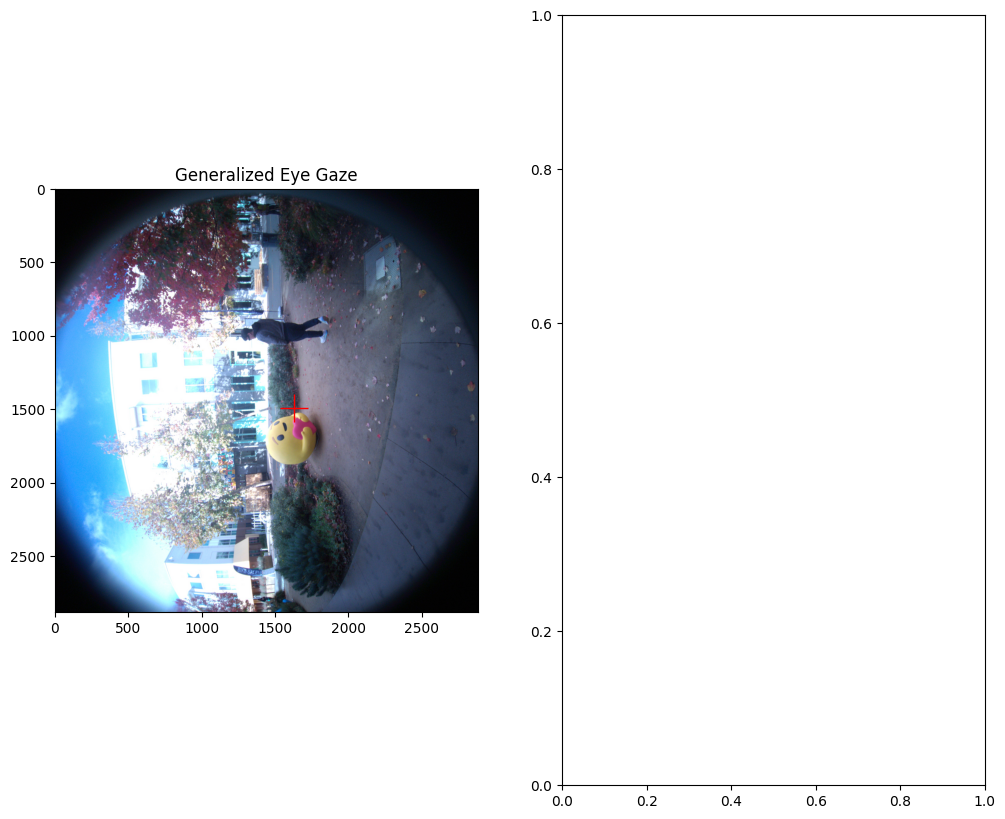

In [141]:
rgb_stream_id = StreamId("214-1")
num_rgb_frames = provider.get_num_data(rgb_stream_id)
rgb_frame = provider.get_image_data_by_index(rgb_stream_id, (int)(num_rgb_frames-5))
assert rgb_frame[0] is not None, "no rgb frame"

image = rgb_frame[0].to_numpy_array()
capture_timestamp_ns = rgb_frame[1].capture_timestamp_ns
generalized_eye_gaze = get_nearest_eye_gaze(generalized_eye_gazes, capture_timestamp_ns)
#calibrated_eye_gaze = get_nearest_eye_gaze(calibrated_eye_gazes, capture_timestamp_ns)
# get projection function
device_calibration = provider.get_device_calibration()
cam_calibration = device_calibration.get_camera_calib(provider.get_label_from_stream_id(rgb_stream_id))
assert cam_calibration is not None, "no camera calibration"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

# Draw a cross at the projected gaze center location on the RGB image at depth 1m
generalized_gaze_center_in_pixels = get_gaze_center_in_pixels(generalized_eye_gaze)
if generalized_gaze_center_in_pixels is not None:
    ax1.imshow(image)
    ax1.plot(generalized_gaze_center_in_pixels[0], generalized_gaze_center_in_pixels[1], '+', c="red", mew=1, ms=20)
    ax1.set_title("Generalized Eye Gaze")
else:
    print(f"Eye gaze center projected to {generalized_gaze_center_in_pixels}, which is out of camera sensor plane.")

#calibrated_gaze_center_in_pixels = get_gaze_center_in_pixels(calibrated_eye_gaze)
#if calibrated_gaze_center_in_pixels is not None:
#    ax2.imshow(image)
#    ax2.plot(calibrated_gaze_center_in_pixels[0], calibrated_gaze_center_in_pixels[1], '+', c="red", mew=1, ms=20)
#    ax2.set_title("Calibrated Eye Gaze")
#else:
 #   print(f"Eye gaze center projected to {calibrated_gaze_center_in_pixels}, which is out of camera sensor plane.")

plt.show()


In [64]:
#print(calibrated_gaze_center_in_pixels[0], calibrated_gaze_center_in_pixels[1])

NameError: ignored

In [142]:
rgb_stream_id = StreamId("214-1")
num_rgb_frames = provider.get_num_data(rgb_stream_id)
rgb_frame = provider.get_image_data_by_index(rgb_stream_id, (int)(num_rgb_frames-4))
assert rgb_frame[0] is not None, "no rgb frame"

image = rgb_frame[0].to_numpy_array()
capture_timestamp_ns = rgb_frame[1].capture_timestamp_ns
generalized_eye_gaze = get_nearest_eye_gaze(generalized_eye_gazes, capture_timestamp_ns)
#calibrated_eye_gaze = get_nearest_eye_gaze(calibrated_eye_gazes, capture_timestamp_ns)

#print(calibrated_gaze_center_in_pixels[0], calibrated_gaze_center_in_pixels[1])

In [143]:
gaze_coords = np.empty((0,3), float)

for idx in range(num_rgb_frames):
  rgb_frame = provider.get_image_data_by_index(rgb_stream_id, (int)(idx))
  assert rgb_frame[0] is not None, "no rgb frame"

  image = rgb_frame[0].to_numpy_array()
  capture_timestamp_ns = rgb_frame[1].capture_timestamp_ns
  generalized_eye_gaze = get_nearest_eye_gaze(generalized_eye_gazes, capture_timestamp_ns)
  #calibrated_eye_gaze = get_nearest_eye_gaze(calibrated_eye_gazes, capture_timestamp_ns)
  generalized_gaze_center_in_pixels = get_gaze_center_in_pixels(generalized_eye_gaze)
  #calibrated_gaze_center_in_pixels = get_gaze_center_in_pixels(calibrated_eye_gaze)

  print(generalized_gaze_center_in_pixels[0], generalized_gaze_center_in_pixels[1], capture_timestamp_ns)
  gaze_coords=np.vstack([gaze_coords, [generalized_gaze_center_in_pixels[0], generalized_gaze_center_in_pixels[1], capture_timestamp_ns]])


1353.9282423416034 2000.2579790758477 104342090512
1171.7599210395758 1962.3194887174818 105342078350
1630.1046784660234 1488.8100482155685 106342082850
1214.0915260712175 1985.1995405626226 107342088100
1417.5114354939344 1174.1837880051007 108342077637
1457.450071484857 1791.0013906530644 109342084562
1382.585390003937 1258.2615484982502 110342087475


In [144]:
num_rgb_frames

7

In [145]:
gaze_coords

array([[1.35392824e+03, 2.00025798e+03, 1.04342091e+11],
       [1.17175992e+03, 1.96231949e+03, 1.05342078e+11],
       [1.63010468e+03, 1.48881005e+03, 1.06342083e+11],
       [1.21409153e+03, 1.98519954e+03, 1.07342088e+11],
       [1.41751144e+03, 1.17418379e+03, 1.08342078e+11],
       [1.45745007e+03, 1.79100139e+03, 1.09342085e+11],
       [1.38258539e+03, 1.25826155e+03, 1.10342087e+11]])

In [146]:
np.savetxt('output.csv', gaze_coords, delimiter=',')

In [82]:
#import peyemmv as pv
import os

os.system('cls')


#	PeyeMMV: Python implementation of EyeMMV’s fixation detection algorithm
#	Copyright (C) 2022 Vassilios Krassanakis (University of West Attica)

#	This program is free software: you can redistribute it and/or modify
#	it under the terms of the GNU General Public License as published by
#	the Free Software Foundation, either version 3 of the License, or
#	(at your option) any later version.

#	This program is distributed in the hope that it will be useful,
#	but WITHOUT ANY WARRANTY; without even the implied warranty of
#	MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#	GNU General Public License for more details.

#	You should have received a copy of the GNU General Public License
#	along with this program.  If not, see <https://www.gnu.org/licenses/>.

#	For further information, please email me: krasvas[at]uniwa[dot]gr

from statistics import mean
from math import sqrt
import matplotlib.pyplot as plt
import itertools

# PeyeMMV parameters:
# file: raw gaze data (x,y,passing time)
# t1,t2: spatial parameters for fixation identification
# min_dur: minimum duration threshold for fixation identification
# report_fix: selecting the value '1', raw gaze data and fixation plot is generated
# Run example (after importing peyemmv module): peyemmv.extract_fixations('demo_data.txt',0.25,0.1,150,'1')

# 3D ray (world camera) -> 2D image , with the help of intrinsic camera calibration

def extract_fixations(file,t1,t2,min_dur,report_fix):

	# Define Euclidean distance between two points
    def dist2p(x1,y1,x2,y2):
        dx=x2-x1
        dy=y2-y1
        return (sqrt((dx**2)+(dy**2)))

    # Read raw data file
    data=open(file,'r')

    # Initialize x,y,t,p(x,y,t)
    x=[]
    y=[]
    t=[]
    p=[]

    # Initialize fixation cluster and fixations list
    fix_clust=[]
    fix_clust_t2=[]
    x_t2=[]
    y_t2=[]
    t_t2=[]

    x_gaze=[]
    y_gaze=[]
    t_gaze=[]
    fixations=[]

    for line in data:
      try:
        print(line)
        line=line.split()
        #append x,y,t values
        x.append(float(line[0]))
        y.append(float(line[1]))
        t.append(float(line[2]))
        p.append([float(line[0]),float(line[1]),float(line[2])])
      except:
        pass

    # Initialize fixation mean point
    fixx=x[0]
    fixy=y[0]

    for point in p:
        dist=dist2p(fixx,fixy,point[0],point[1])

        #check spatial threshold
        if dist<t1:
            x_gaze.append(point[0])
            y_gaze.append(point[1])
            t_gaze.append(point[2])
            fixx=mean(x_gaze)
            fixy=mean(y_gaze)

        else:
            # Put all gaze points in a fixation cluster
            fix_clust.append([x_gaze,y_gaze,t_gaze])
            if len(fix_clust[0][0])>=1:
                fixx_clust=mean(fix_clust[0][0])
                fixy_clust=mean(fix_clust[0][1])

                for (xg,yg,tg) in zip(fix_clust[0][0],fix_clust[0][1],fix_clust[0][2]):
                    if dist2p(fixx_clust,fixy_clust,xg,yg)<t2:
                        x_t2.append(xg)
                        y_t2.append(yg)
                        t_t2.append(tg)

                fixx_clust_t2=mean(x_t2)
                fixy_clust_t2=mean(y_t2)
                fixdur_clust_t2=t_t2[-1]-t_t2[0]

                # Check minimum duration threshold
                if fixdur_clust_t2>=min_dur:
                    #mean_x,mean_y,dur,start,end
                    fixations.append([fixx_clust_t2,fixy_clust_t2,fixdur_clust_t2,t_t2[0],t_t2[-1],len(t_t2)])

            # Initialize fixation mean point and gaze points
            fixx=point[0]
            fixy=point[1]
            x_gaze=[]
            y_gaze=[]
            t_gaze=[]
            fix_clust=[]
            fix_clust_t2=[]
            x_t2=[]
            y_t2=[]
            t_t2=[]

    # Generate fixation report (plot values)
    if report_fix=='1':
        #print final fixations
        x_fix=[]
        y_fix=[]
        dur_fix=[]
        print("Fixation_ID [X_coord, Y_coord, Duration, Start_time, End_time, No_gaze_points]")

        # Define a fixation counter
        fix_count=0
        for fix in fixations:
            fix_count=fix_count+1
            print (fix_count,fix)
            x_fix.append(fix[0])
            y_fix.append(fix[1])
            dur_fix.append(fix[2])

        plt.title("Fixation points")
        plt.xlabel("Horizontal coordinates (tracker units)")
        plt.ylabel("Vertical coordinates (tracker units)")

        plt.scatter(x,y,color='blue',marker='+')
        plt.scatter(x_fix,y_fix,color='red',marker='.')
        plt.legend(['raw gaze data','fixation centers and their durations'],loc='best')
        for i in range(len(x_fix)):
            plt.text(x_fix[i],y_fix[i],"{:.1f}".format(dur_fix[i]),color='red')
        plt.grid()
        plt.show()
    else:
        pass

    return(fixations)



fixations=extract_fixations('gaze.txt',110,110,1,'1')




FileNotFoundError: ignored

In [ ]:
fixations

[]

In [ ]:
#import peyemmv as pv
import os

os.system('cls')


#	PeyeMMV: Python implementation of EyeMMV’s fixation detection algorithm
#	Copyright (C) 2022 Vassilios Krassanakis (University of West Attica)

#	This program is free software: you can redistribute it and/or modify
#	it under the terms of the GNU General Public License as published by
#	the Free Software Foundation, either version 3 of the License, or
#	(at your option) any later version.

#	This program is distributed in the hope that it will be useful,
#	but WITHOUT ANY WARRANTY; without even the implied warranty of
#	MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#	GNU General Public License for more details.

#	You should have received a copy of the GNU General Public License
#	along with this program.  If not, see <https://www.gnu.org/licenses/>.

#	For further information, please email me: krasvas[at]uniwa[dot]gr

from statistics import mean
from math import sqrt
import matplotlib.pyplot as plt
import itertools

# PeyeMMV parameters:
# file: raw gaze data (x,y,passing time)
# t1,t2: spatial parameters for fixation identification
# min_dur: minimum duration threshold for fixation identification
# report_fix: selecting the value '1', raw gaze data and fixation plot is generated
# Run example (after importing peyemmv module): peyemmv.extract_fixations('demo_data.txt',0.25,0.1,150,'1')

# 3D ray (world camera) -> 2D image , with the help of intrinsic camera calibration

def extract_fixations(file,t1,t2,min_dur,report_fix):

	# Define Euclidean distance between two points
    def dist2p(x1,y1,x2,y2):
        dx=x2-x1
        dy=y2-y1
        return (sqrt((dx**2)+(dy**2)))

    # Read raw data file
    data=open(file,'r')

    # Initialize x,y,t,p(x,y,t)
    x=[]
    y=[]
    t=[]
    p=[]

    # Initialize fixation cluster and fixations list
    fix_clust=[]
    fix_clust_t2=[]
    x_t2=[]
    y_t2=[]
    t_t2=[]

    x_gaze=[]
    y_gaze=[]
    t_gaze=[]
    fixations=[]

    for line in data:
        line=line.split()
        #append x,y,t values
        x.append(float(line[0]))
        y.append(float(line[1]))
        t.append(float(line[2]))
        p.append([float(line[0]),float(line[1]),float(line[2])])

    # Initialize fixation mean point
    fixx=x[0]
    fixy=y[0]

    for point in p:
        dist=dist2p(fixx,fixy,point[0],point[1])

        #check spatial threshold
        if dist<t1:
            x_gaze.append(point[0])
            y_gaze.append(point[1])
            t_gaze.append(point[2])
            fixx=mean(x_gaze)
            fixy=mean(y_gaze)

        else:
            # Put all gaze points in a fixation cluster
            fix_clust.append([x_gaze,y_gaze,t_gaze])
            if len(fix_clust[0][0])>=1:
                fixx_clust=mean(fix_clust[0][0])
                fixy_clust=mean(fix_clust[0][1])

                for (xg,yg,tg) in zip(fix_clust[0][0],fix_clust[0][1],fix_clust[0][2]):
                    if dist2p(fixx_clust,fixy_clust,xg,yg)<t2:
                        x_t2.append(xg)
                        y_t2.append(yg)
                        t_t2.append(tg)

                fixx_clust_t2=mean(x_t2)
                fixy_clust_t2=mean(y_t2)
                fixdur_clust_t2=t_t2[-1]-t_t2[0]

                # Check minimum duration threshold
                if fixdur_clust_t2>=min_dur:
                    #mean_x,mean_y,dur,start,end
                    fixations.append([fixx_clust_t2,fixy_clust_t2,fixdur_clust_t2,t_t2[0],t_t2[-1],len(t_t2)])

            # Initialize fixation mean point and gaze points
            fixx=point[0]
            fixy=point[1]
            x_gaze=[]
            y_gaze=[]
            t_gaze=[]
            fix_clust=[]
            fix_clust_t2=[]
            x_t2=[]
            y_t2=[]
            t_t2=[]

    # Generate fixation report (plot values)
    if report_fix=='1':
        #print final fixations
        x_fix=[]
        y_fix=[]
        dur_fix=[]
        print("Fixation_ID [X_coord, Y_coord, Duration, Start_time, End_time, No_gaze_points]")

        # Define a fixation counter
        fix_count=0
        for fix in fixations:
            fix_count=fix_count+1
            print (fix_count,fix)
            x_fix.append(fix[0])
            y_fix.append(fix[1])
            dur_fix.append(fix[2])

        plt.title("Fixation points")
        plt.xlabel("Horizontal coordinates (tracker units)")
        plt.ylabel("Vertical coordinates (tracker units)")

        plt.scatter(x,y,color='blue',marker='+')
        plt.scatter(x_fix,y_fix,color='red',marker='.')
        plt.legend(['raw gaze data','fixation centers and their durations'],loc='best')
        for i in range(len(x_fix)):
            plt.text(x_fix[i],y_fix[i],"{:.1f}".format(dur_fix[i]),color='red')
        plt.grid()
        plt.show()
    else:
        pass

    return(fixations)



fixations=extract_fixations('demo_data.txt',0.25,0.1,150,'1')




test
